In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime, date
import matplotlib.cm as cm

from termcolor import colored
import os
os.chdir('..')
from src.utils.utils import get_column_category, get_time_features, replace_implausible_zeros

In [2]:
%load_ext autoreload
%autoreload 2

# Table of contents
1. [Overview](#overview)
2. [Data](#data)
3. [EDA](#eda)
    - [Target](#target)
    - [Correlation](#corr)
    - [Missing Values](#na)
    - [Temperature](#temp)
4. [Preprocessing](#prep)
    - [Implausible values](#impvalues)
    - [Impute NaN](#imputenan)

## Overview <a name="overview"></a>
The Acea Group is one of the leading Italian multiutility operators. Listed on the Italian Stock Exchange since 1999, the company manages and develops water and electricity networks and environmental services. Acea is the foremost Italian operator in the water services sector supplying 9 million inhabitants in Lazio, Tuscany, Umbria, Molise, Campania.

In this competition we will focus only on the water sector to help Acea Group preserve precious waterbodies. As it is easy to imagine, a water supply company struggles with the need to forecast the water level in a waterbody (water spring, lake, river, or aquifer) to handle daily consumption. During fall and winter waterbodies are refilled, but during spring and summer they start to drain. To help preserve the health of these waterbodies it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

## Data <a name="data"></a>
The reality is that each waterbody has such unique characteristics that their attributes are not linked to each other. This analytics competition uses datasets that are completely independent from each other. However, it is critical to understand total availability in order to preserve water across the country.

Each dataset represents a different kind of waterbody. As each waterbody is different from the other, the related features are also different. So, if for instance we consider a water spring we notice that its features are different from those of a lake. These variances are expected based upon the unique behavior and characteristics of each waterbody. The Acea Group deals with four different type of waterbodies: water springs, lakes, rivers and aquifers.

In [3]:
aq_auser = pd.read_csv("data/Aquifer_Auser.csv")
aq_doganella = pd.read_csv("data/Aquifer_Doganella.csv")
aq_luco = pd.read_csv("data/Aquifer_Luco.csv")
aq_petrignano = pd.read_csv("data/Aquifer_Petrignano.csv")
lake_biliancino = pd.read_csv("data/Lake_Bilancino.csv")
river_arno = pd.read_csv("data/River_Arno.csv")
ws_amiata = pd.read_csv("data/Water_Spring_Amiata.csv")
ws_lupa = pd.read_csv("data/Water_Spring_Lupa.csv")
ws_madonna = pd.read_csv("data/Water_Spring_Madonna_di_Canneto.csv")

In [4]:
datasets = []
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        if '.csv' in filename:
            datasets += list([filename])

datasets_df = pd.DataFrame(columns=['filename'], data=datasets)
datasets_df['waterbody_type'] = datasets_df.filename.apply(lambda x: x.split('_')[0])

In [5]:
datasets_df

,filename,waterbody_type
0,Aquifer_Auser.csv,Aquifer
1,Aquifer_Doganella.csv,Aquifer
2,Aquifer_Luco.csv,Aquifer
3,Aquifer_Petrignano.csv,Aquifer
4,Lake_Bilancino.csv,Lake
5,River_Arno.csv,River
6,Water_Spring_Amiata.csv,Water
7,Water_Spring_Lupa.csv,Water
8,Water_Spring_Madonna_di_Canneto.csv,Water


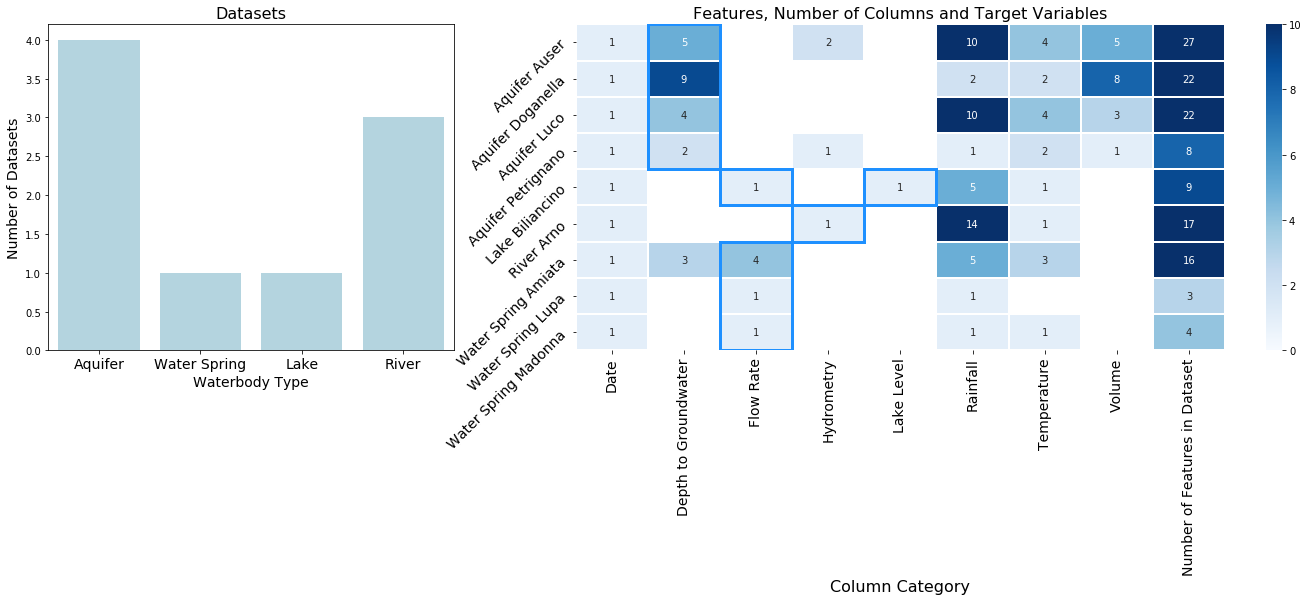

In [6]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,6),  gridspec_kw={'width_ratios': [1,2]})

sns.countplot(datasets_df.waterbody_type, palette=['lightblue'], ax= ax[0])
ax[0].set_title('Datasets', fontsize=16)
ax[0].set_ylabel('Number of Datasets', fontsize=14)
ax[0].set_xlabel('Waterbody Type', fontsize=14)
ax[0].set_xticklabels(labels=['Aquifer', 'Water Spring', 'Lake', 'River'], fontsize=14)

temp_df = pd.DataFrame({'column_name' : aq_auser.columns, 'waterbody_type':'Aquifer Auser'})
temp_df = temp_df.append(pd.DataFrame({'column_name' : aq_doganella.columns, 'waterbody_type':'Aquifer Doganella'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : aq_luco.columns, 'waterbody_type':'Aquifer Luco'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : aq_petrignano.columns, 'waterbody_type':'Aquifer Petrignano'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : lake_biliancino.columns, 'waterbody_type':'Lake Biliancino'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : river_arno.columns, 'waterbody_type':'River Arno'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : ws_amiata.columns, 'waterbody_type':'Water Spring Amiata'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : ws_lupa.columns, 'waterbody_type':'Water Spring Lupa'}))
temp_df = temp_df.append(pd.DataFrame({'column_name' : ws_madonna.columns, 'waterbody_type':'Water Spring Madonna'}))

temp_df['column_category'] = temp_df.column_name.apply(lambda x: get_column_category(x))

temp_df = temp_df.groupby('waterbody_type').column_category.value_counts().to_frame()
temp_df.columns = ['counts']
temp_df = temp_df.reset_index(drop=False)
temp_df = temp_df.pivot(index='waterbody_type', columns='column_category')['counts']
temp_df['Number of Features in Dataset'] = temp_df.sum(axis=1)

sns.heatmap(temp_df, cmap='Blues', linewidth=1, ax=ax[1], vmin=0, vmax=10, annot=True)

#ax[1].set_ylabel('Waterbody Type', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_xlabel('Column Category', fontsize=16)
ax[1].set_title('Features, Number of Columns and Target Variables', fontsize=16)
ax[1].add_patch(Rectangle((1, 0), 1, 4, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((2, 4), 1, 1, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((4, 4), 1, 1, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((3, 5), 1, 1, fill=False, alpha=1, color='dodgerblue', lw=3))
ax[1].add_patch(Rectangle((2, 6), 1, 3, fill=False, alpha=1, color='dodgerblue', lw=3))
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    #tick.label.set_rotation('horizontal')
    tick.label.set_rotation(45) 

plt.show()

In [7]:
waterbodies_df = aq_auser.merge(aq_doganella, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(aq_luco, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(aq_petrignano, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(lake_biliancino[['Date','Temperature_Le_Croci','Lake_Level', 'Flow_Rate']], on='Date', how='outer') # Only merge specific columns because 'Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci' are shared with river_arno_df
waterbodies_df = waterbodies_df.merge(river_arno, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(ws_amiata, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(ws_lupa, on='Date', how='outer')
waterbodies_df = waterbodies_df.merge(ws_madonna, on='Date', how='outer')

waterbodies_df['Date_dt'] = pd.to_datetime(waterbodies_df.Date, format = '%d/%m/%Y')
waterbodies_df = waterbodies_df.sort_values(by='Date_dt').reset_index(drop=True)

## EDA <a name="eda"></a>

### Target Variables <a name="target"></a>

C:\Users\kosta\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


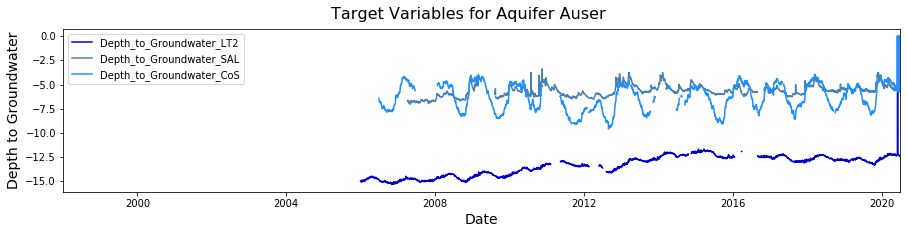

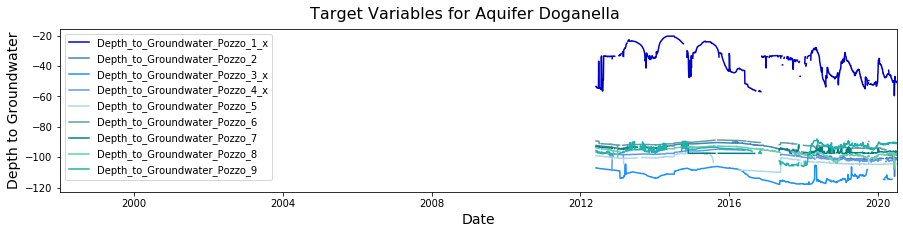

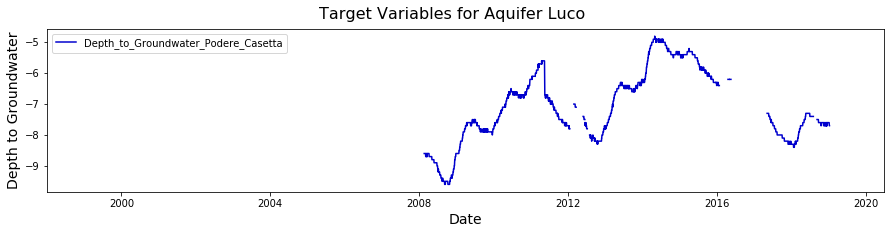

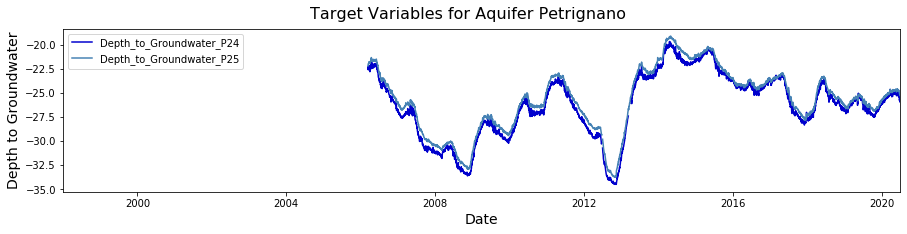

In [8]:
n_targets = 1
height=3

custom_colors = ['mediumblue', 'steelblue', 'dodgerblue', 'cornflowerblue', 'lightblue', 
                 'cadetblue', 'teal', 'mediumaquamarine', 'lightseagreen']
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Auser', fontsize=16)

for i, target in enumerate(['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', ]): # 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_DIEC']): not targets
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Doganella', fontsize=16)

for i, target in enumerate(['Depth_to_Groundwater_Pozzo_1_x', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3_x', 'Depth_to_Groundwater_Pozzo_4_x',
               'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8',
              'Depth_to_Groundwater_Pozzo_9']):
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Luco', fontsize=16)
for i, target in enumerate(['Depth_to_Groundwater_Podere_Casetta',]): # 'Depth_to_Groundwater_Pozzo_1_y', 'Depth_to_Groundwater_Pozzo_3_y', 'Depth_to_Groundwater_Pozzo_4_y']): not targets
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Aquifer Petrignano', fontsize=16)

for i, target in enumerate(['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25']):
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

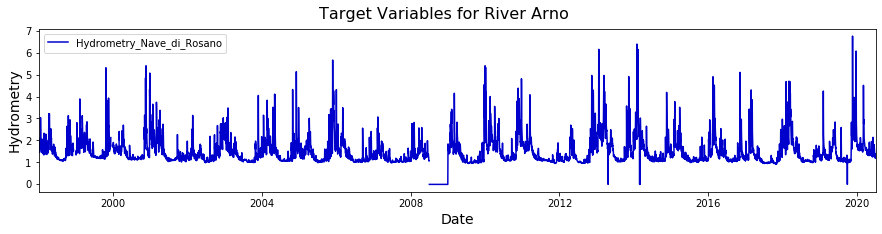

In [9]:
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for River Arno', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Hydrometry_Nave_di_Rosano.replace({np.nan : np.inf}), ax=ax, color=custom_colors[0], label='Hydrometry_Nave_di_Rosano')
ax.set_ylabel('Hydrometry', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

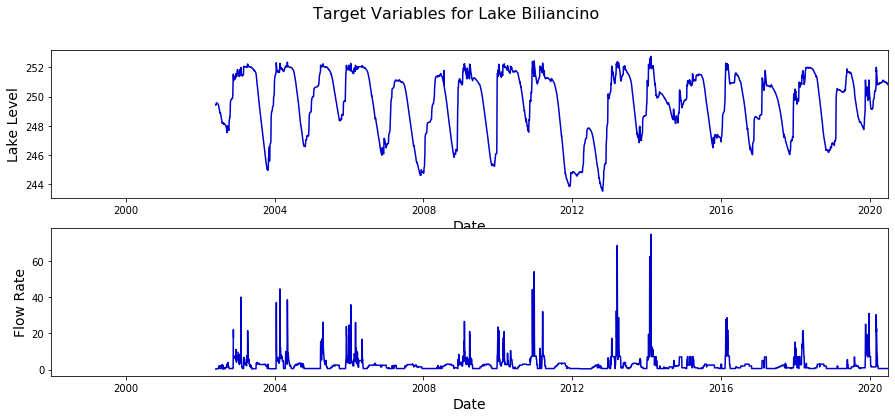

In [10]:
n_targets = 2
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Lake Biliancino', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Lake_Level.replace({np.nan : np.inf}), ax=ax[0], color=custom_colors[0])
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Flow_Rate.replace({np.nan : np.inf}), ax=ax[1], color=custom_colors[0])
ax[0].set_ylabel('Lake Level', fontsize=14)
ax[1].set_ylabel('Flow Rate', fontsize=14)

for i in range(n_targets):
    ax[i].set_xlabel('Date', fontsize=14)
    ax[i].set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

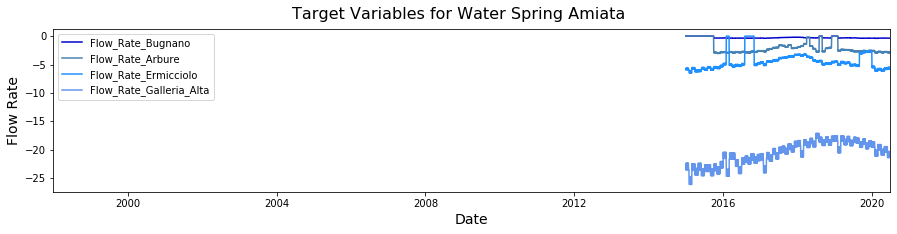

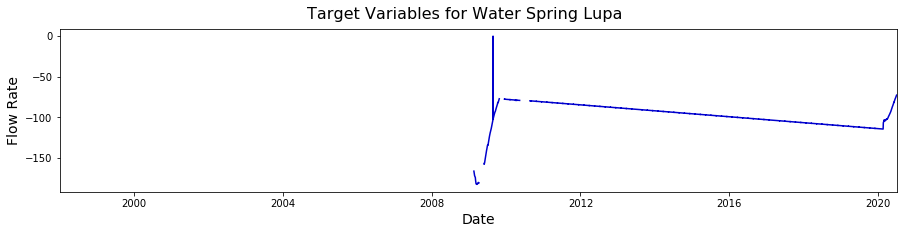

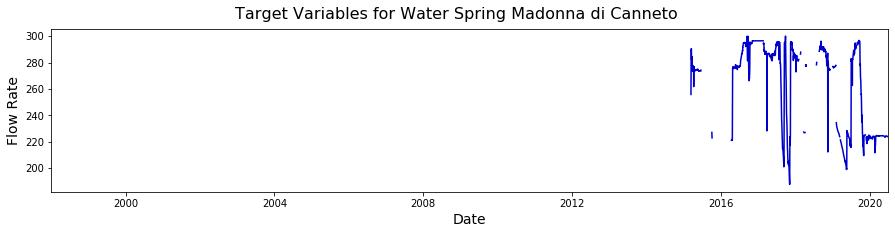

In [11]:
n_targets = 1
f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Water Spring Amiata', fontsize=16)

for i, target in enumerate(['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta']):
    sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df[target].replace({np.nan : np.inf}), ax=ax, color=custom_colors[i], label=target)

ax.set_ylabel('Flow Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()


f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Water Spring Lupa', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Flow_Rate_Lupa.replace({np.nan : np.inf}), ax=ax, color=custom_colors[0])

ax.set_ylabel('Flow Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

f, ax = plt.subplots(nrows=n_targets, ncols=1, figsize=(15, height*n_targets))
f.suptitle('Target Variables for Water Spring Madonna di Canneto', fontsize=16)
sns.lineplot(x=waterbodies_df.Date_dt, y=waterbodies_df.Flow_Rate_Madonna_di_Canneto.replace({np.nan : np.inf}), ax=ax, color=custom_colors[0])

ax.set_ylabel('Flow Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([date(1998, 1, 1), date(2020, 6, 30)])
plt.show()

### Correlation <a name="corr"></a>

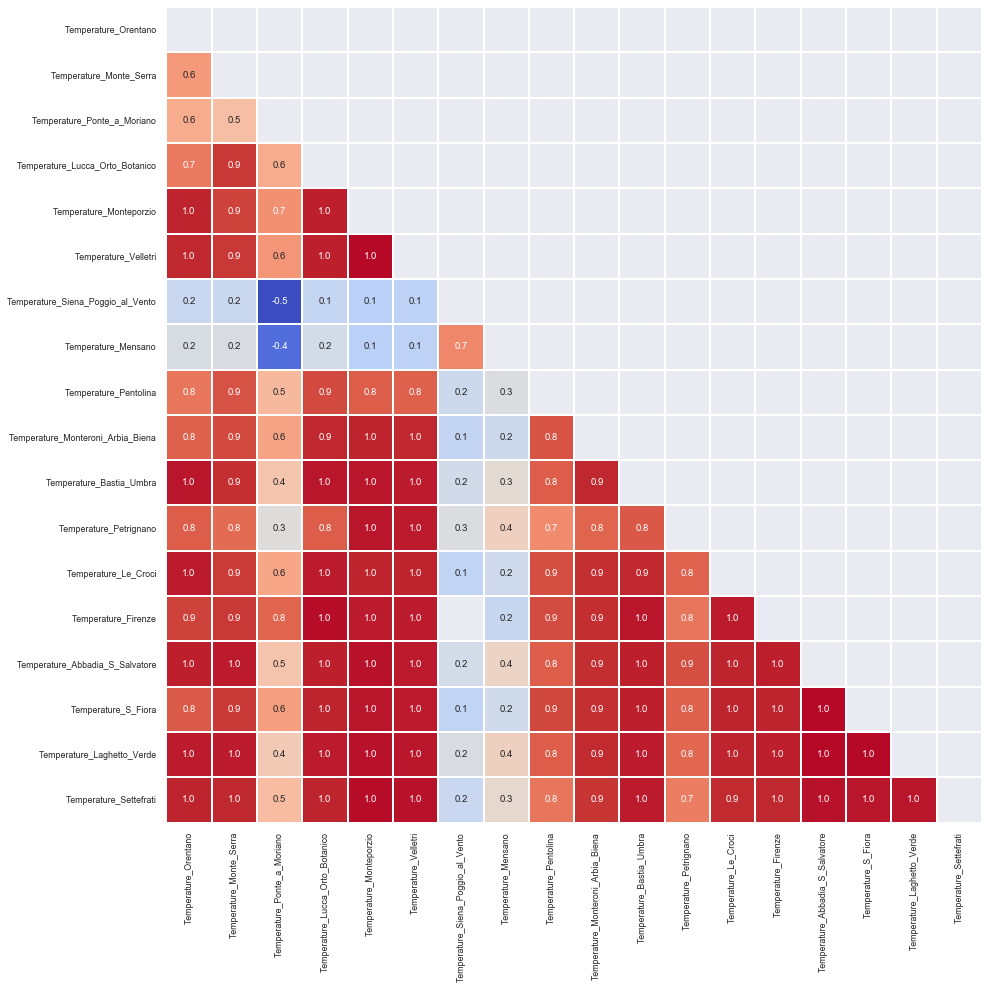

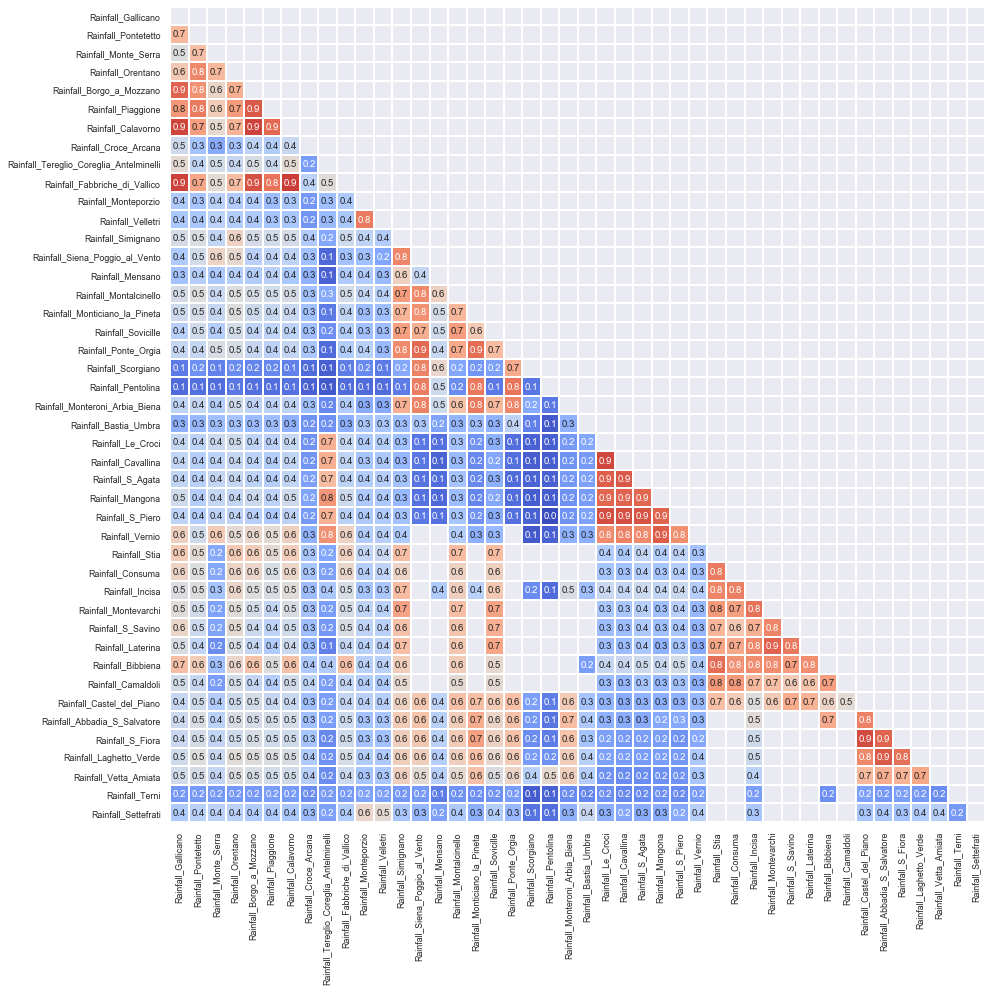

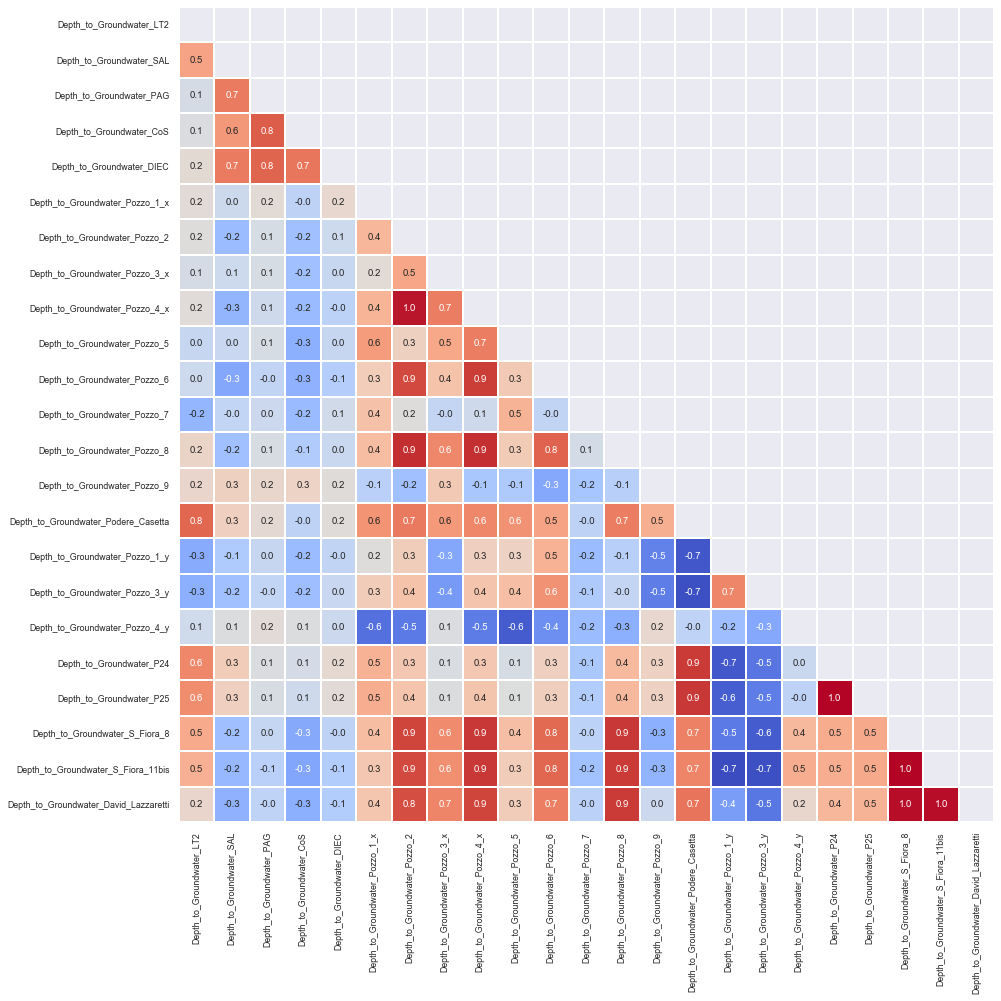

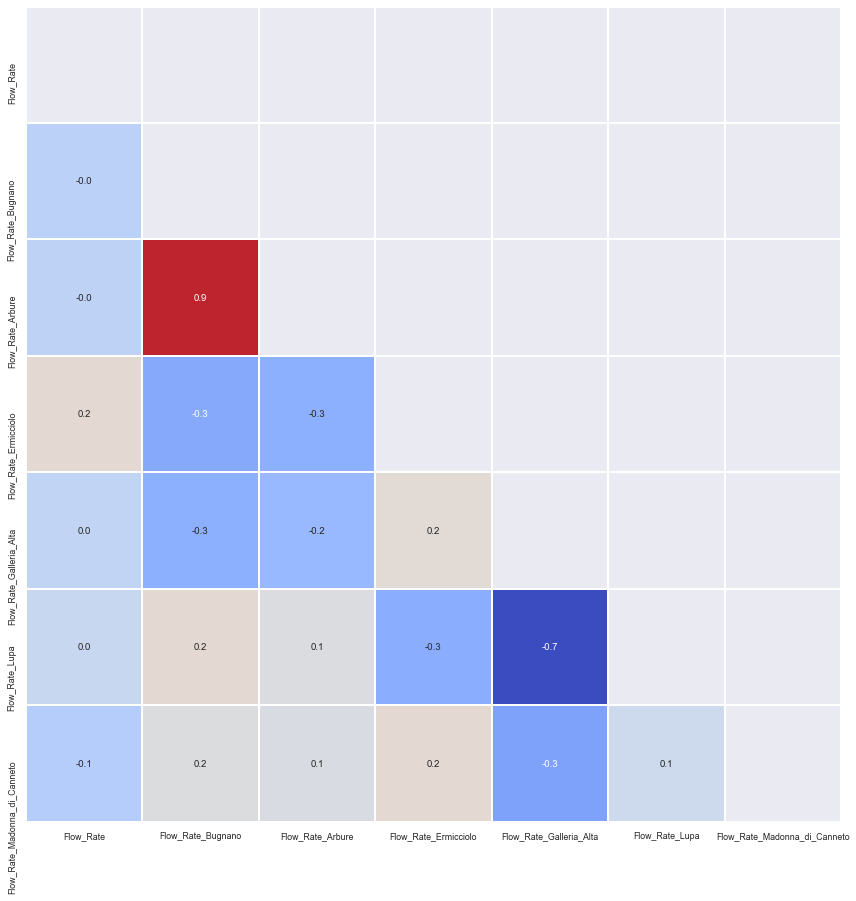

In [12]:
feature_groups = ['Temperature','Rainfall','Depth','Flow']
for fg in feature_groups:
    fg_cols = [c for c in waterbodies_df.columns if c.startswith(fg)]
    sns.set(font_scale=0.8)
    c = waterbodies_df[fg_cols].corr()
    mask = np.triu(c.corr())
    plt.figure(figsize=(15, 15))
    sns.heatmap(c,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

<b>Note:</b> We observe high correlation between subregion features. We could potentially merge some of those features

### Missing Values <a name="na"></a>

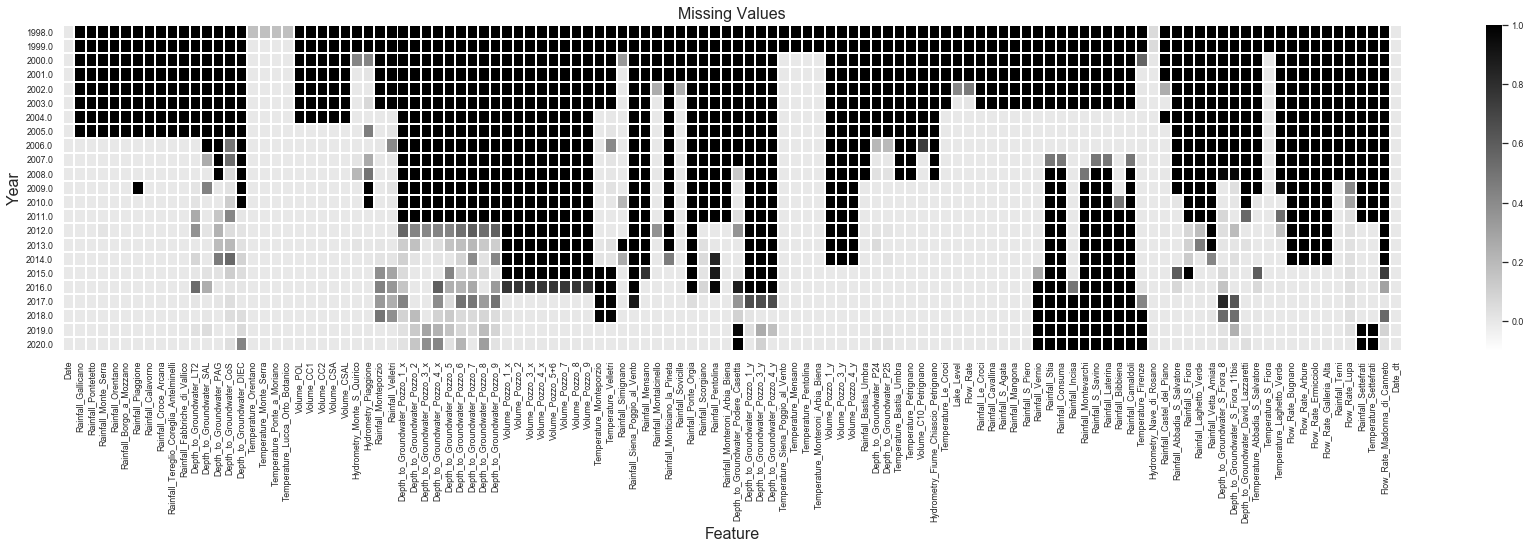

In [13]:
waterbodies_df['year'] = waterbodies_df.Date.apply(lambda x: x.split('/')[2] if x==x else x)
waterbodies_df['year'] = pd.to_numeric(waterbodies_df['year'], errors='coerce')

temp = waterbodies_df[[c for c in waterbodies_df.columns if c != 'year']].isna().astype(int)
temp['year'] = waterbodies_df.year
temp = temp.groupby('year').mean()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,6))

sns.heatmap(temp,  
            cmap='binary', vmin=-0.1, vmax=1, ax=ax, linewidth=1)#[0])
ax.set_ylabel('Year', fontsize=16)
ax.set_xlabel('Feature', fontsize=16)
ax.set_title('Missing Values', fontsize=16)

plt.show()

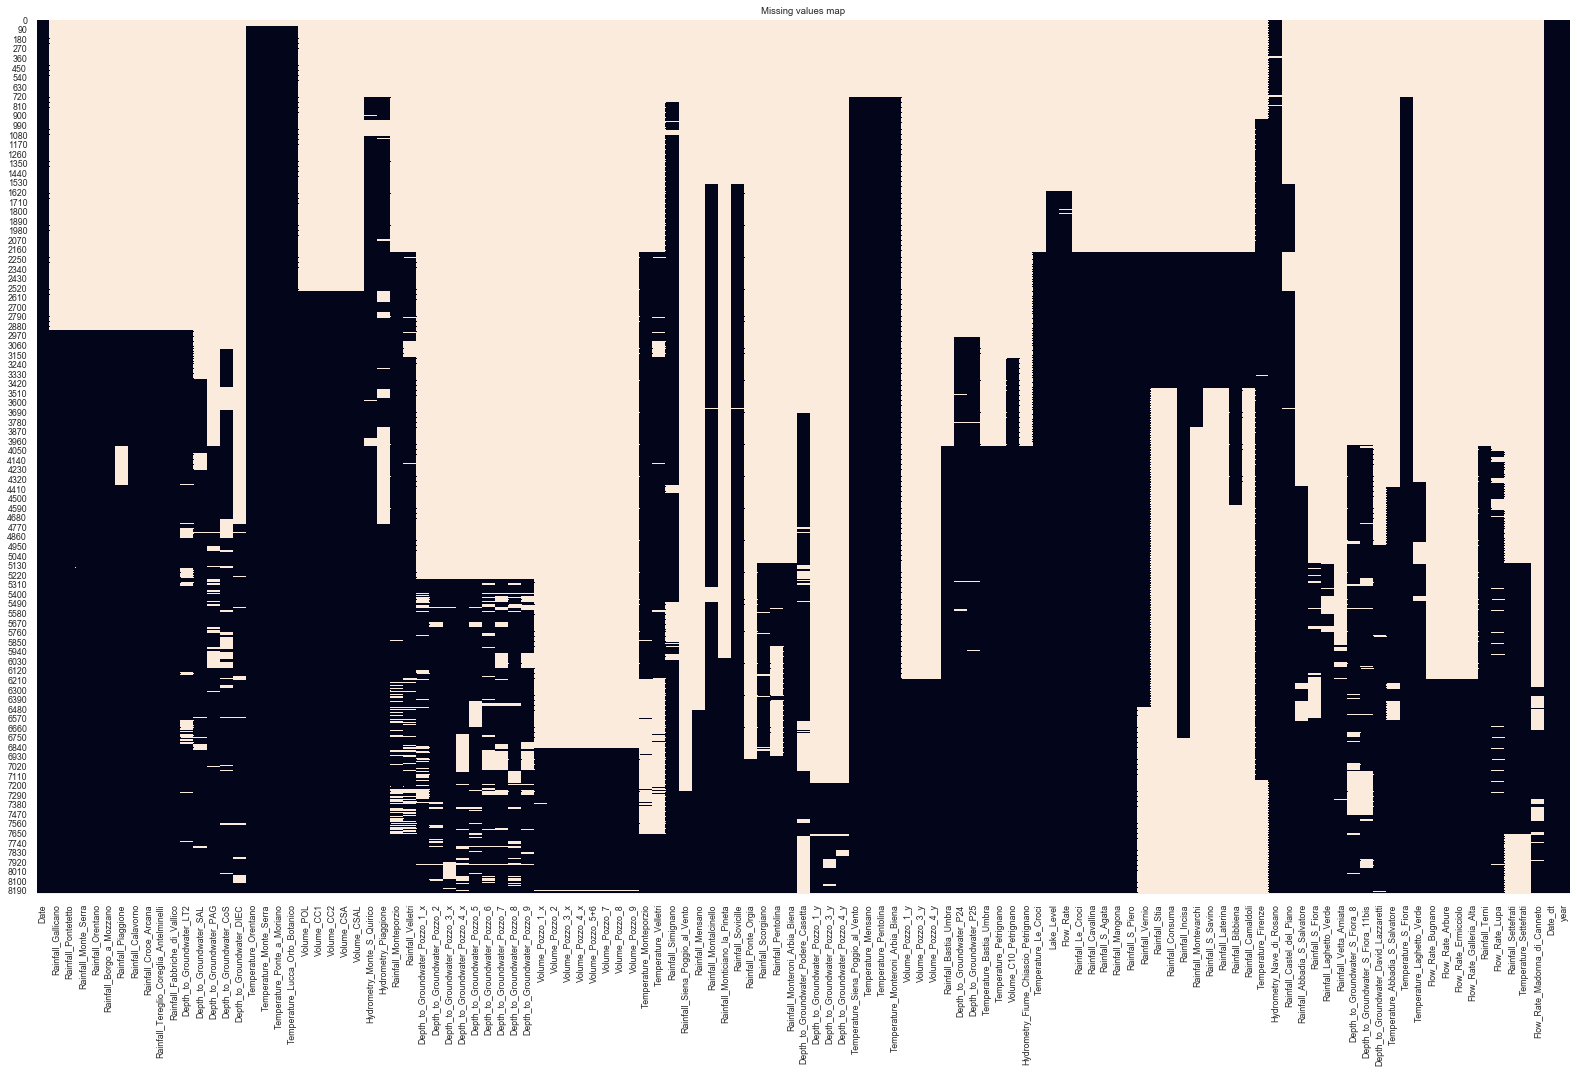

In [14]:
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(waterbodies_df.isnull(), cbar=False,ax=ax)
ax.set_title('Missing values map')
plt.tight_layout()

### Temperature  <a name="temp"></a>

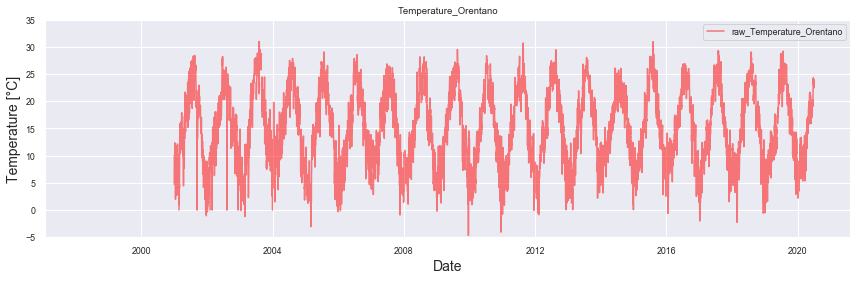

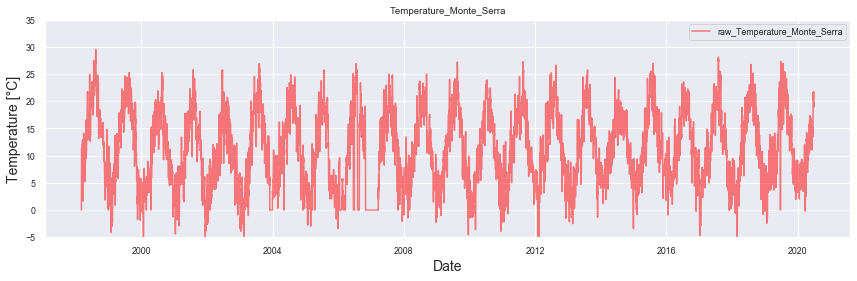

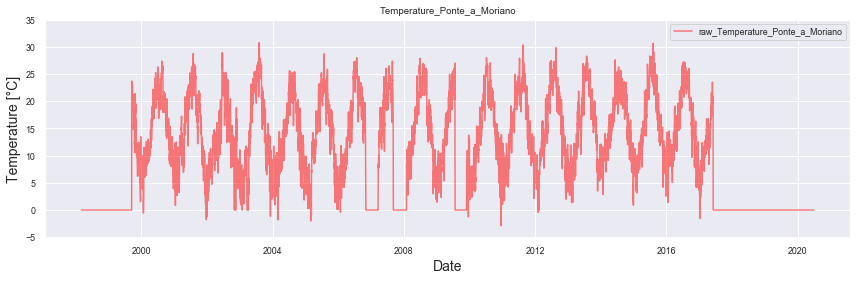

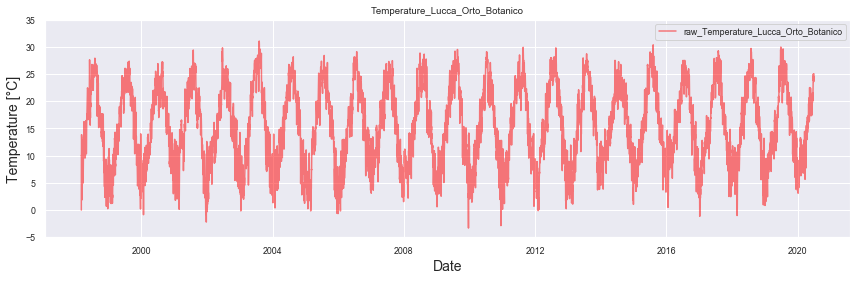

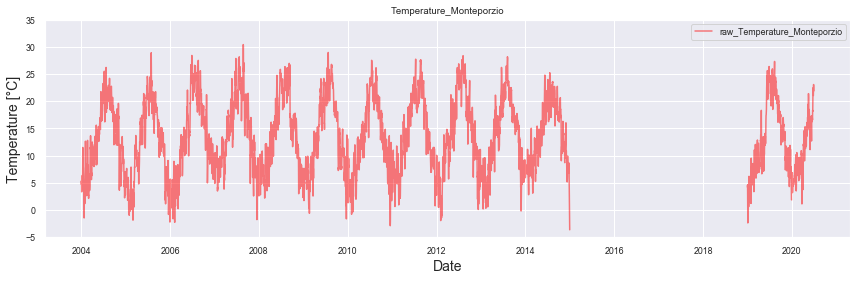

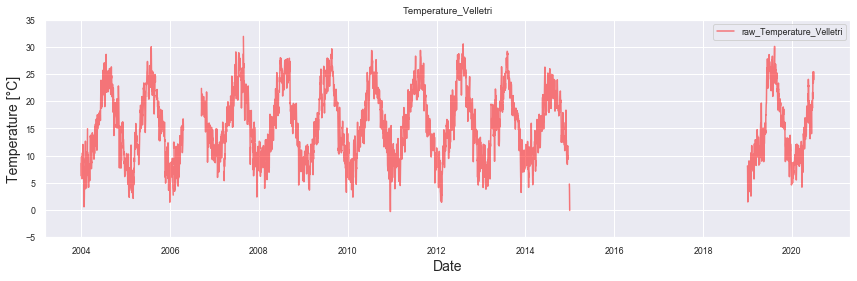

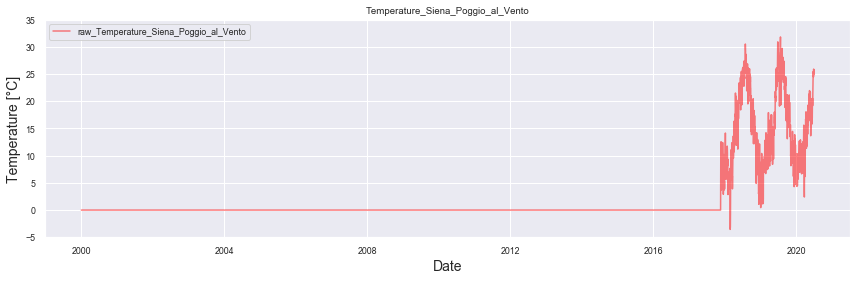

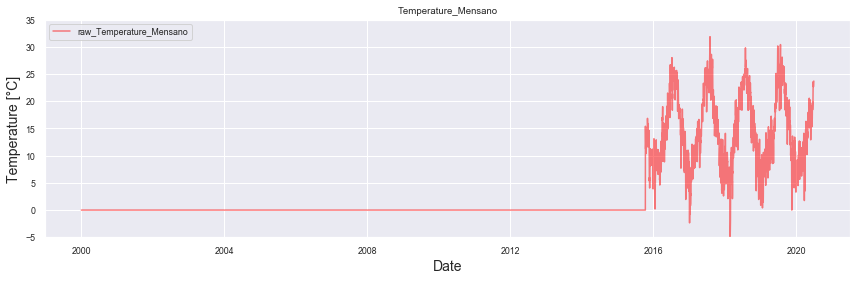

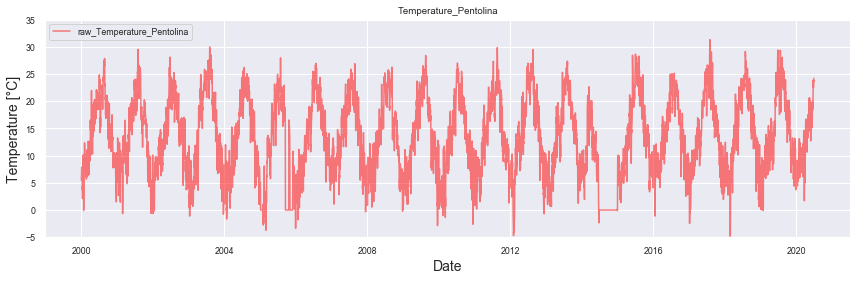

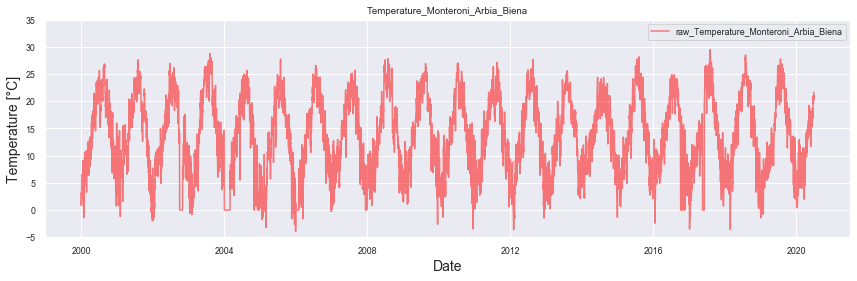

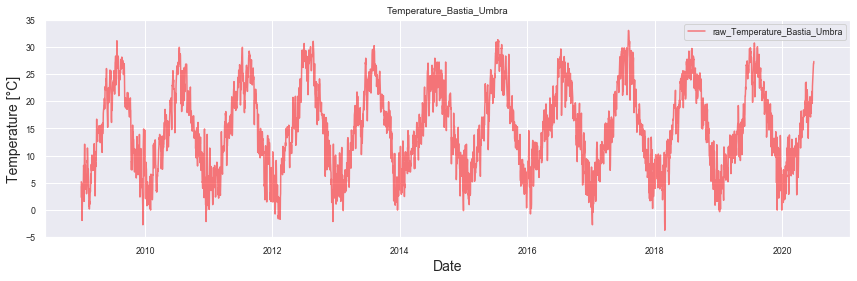

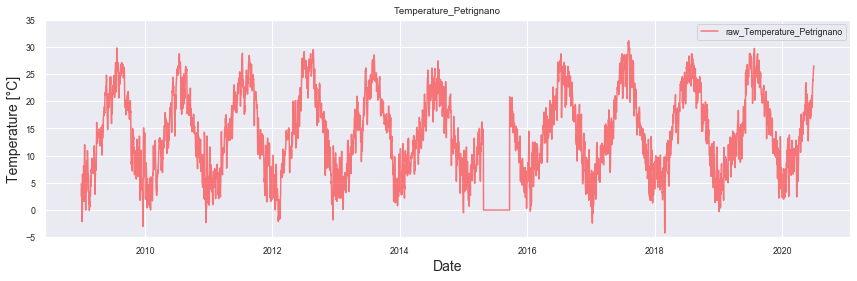

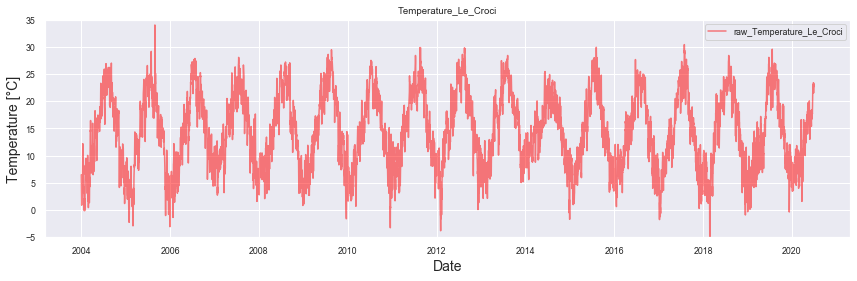

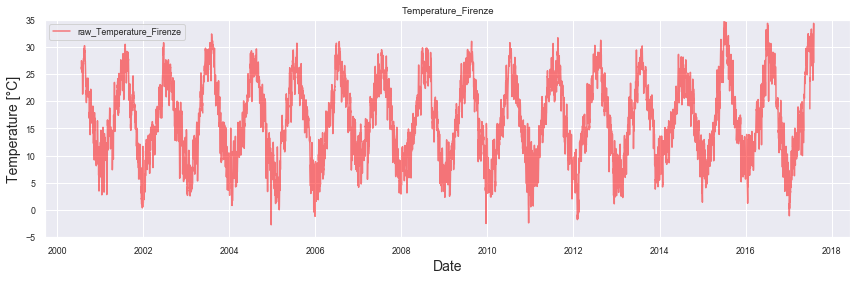

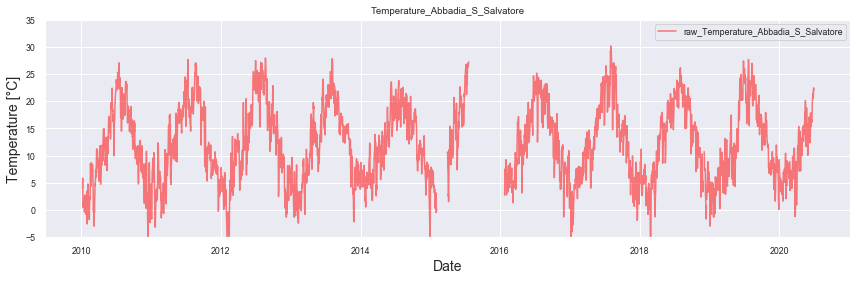

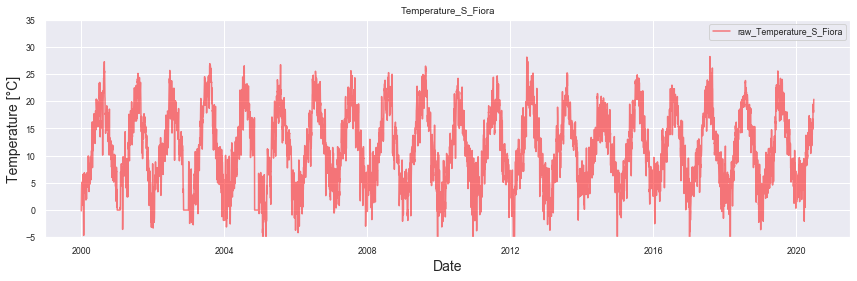

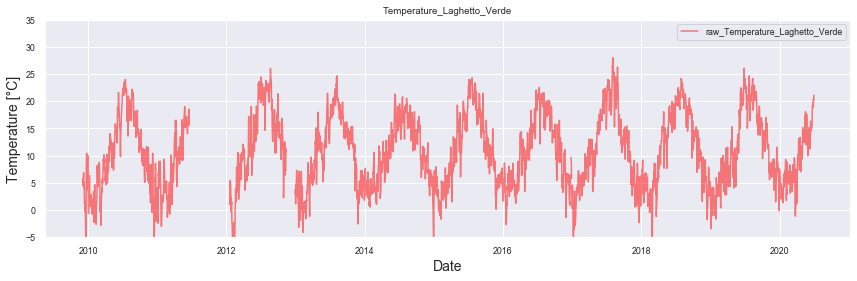

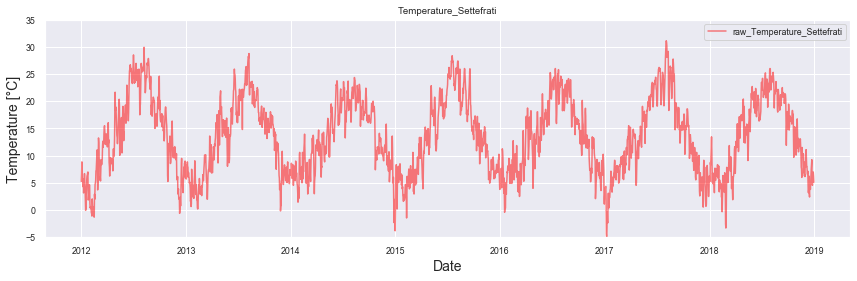

In [110]:
temperature_cols = waterbodies_df.columns[waterbodies_df.columns.str.startswith('Temperature')]
for i, col in enumerate(temperature_cols):
    f, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(y=waterbodies_df[col].replace({np.nan:np.inf}).values, x=waterbodies_df.Date_dt, ax=ax, label='raw_'+col,color='red', alpha=0.5)
    ax.set_title(col)
    ax.set_ylabel('Temperature [°C]', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylim([-5, 35])
    plt.tight_layout()
    plt.show()

<b>Note 1:</b> We observe many implausibly imputed values, mainly zeros.

<b>Note 2:</b> <i>Poggio al Vento</i> and <i>Mensano</i> temperatures have long data gaps. However, they are very close geographically to other areas with much better data coverage so we could replace them.

## Preprocessing  <a name="prep"></a>

In [16]:
# Absolute flow rate
waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Flow')]] = np.abs(waterbodies_df[waterbodies_df.columns[waterbodies_df.columns.str.startswith('Flow')]])

In [17]:
# Unify unit for flow rate
waterbodies_df['Flow_Rate'] = waterbodies_df['Flow_Rate']*1000

In [45]:
# delete data before 2000 as most of data is missing. Still 20 years worth of data remaining
waterbodies_df = waterbodies_df[waterbodies_df.year>= 2000].reset_index(drop=True)

In [46]:
waterbodies_df = get_time_features(waterbodies_df)
waterbodies_df.month = waterbodies_df.month.astype(int)
waterbodies_df.year = waterbodies_df.year.astype(int)

### Implausible values <a name="impvalues"></a>

In [111]:
for col in temperature_cols:
    waterbodies_df[col] = remove_erroneous_temp_values(waterbodies_df, col)

### Impute missing values <a name="imputenan"></a>